In [18]:
%run ../../main.py
%run ./CAR_creation.ipynb

In [19]:
import pyarc.qcba as qcba
import pyarc.utils.plotting as plotils

In [20]:
from pyarc.qcba.data_structures import *

quant_rules = [ QuantitativeCAR(r) for r in rules ]
rules

[CAR {a-list-celebrities=<0;2)} => {class=box-office-bomb} sup: 0.31 conf: 1.00 len: 2, id: 89,
 CAR {estimated-budget=<250;300)} => {class=main-stream-hit} sup: 0.06 conf: 1.00 len: 2, id: 51,
 CAR {estimated-budget=<0;50),a-list-celebrities=<4;6)} => {class=critical-success} sup: 0.06 conf: 1.00 len: 3, id: 71,
 CAR {a-list-celebrities=<6;8)} => {class=critical-success} sup: 0.03 conf: 1.00 len: 2, id: 48,
 CAR {estimated-budget=<100;150),a-list-celebrities=<4;6)} => {class=main-stream-hit} sup: 0.03 conf: 1.00 len: 3, id: 57,
 CAR {estimated-budget=<150;200),a-list-celebrities=<4;6)} => {class=main-stream-hit} sup: 0.03 conf: 1.00 len: 3, id: 63,
 CAR {estimated-budget=<200;250)} => {class=box-office-bomb} sup: 0.06 conf: 0.67 len: 2, id: 56,
 CAR {estimated-budget=<0;50)} => {class=box-office-bomb} sup: 0.14 conf: 0.62 len: 2, id: 76,
 CAR {a-list-celebrities=<4;6)} => {class=main-stream-hit} sup: 0.11 conf: 0.50 len: 2, id: 80]

In [21]:
ds = movies_train_undiscr.reset_index()
quant_dataset = QuantitativeDataFrame(ds)

quant_dataset.dataframe.head()

,estimated-budget,a-list-celebrities,class
0,160,1,box-office-bomb
1,55,2,box-office-bomb
2,78,1,box-office-bomb
3,66,3,box-office-bomb
4,223,2,box-office-bomb


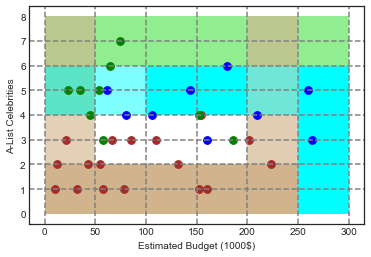

In [22]:
utils.plot_quant_rules(quant_rules)

In [23]:
from pyarc.qcba.transformation import *


qcba_transformation = QCBATransformation(quant_dataset)

In [24]:
quant_dataset.dataframe["estimated-budget"]#.column("estimated-budget")
quant_dataset._QuantitativeDataFrame__preprocessed_columns


{'a-list-celebrities': array([1, 2, 3, 4, 5, 6, 7]),
 'class': array(['box-office-bomb', 'critical-success', 'main-stream-hit'], 
       dtype='<U16'),
 'estimated-budget': array([ 10,  12,  21,  23,  32,  35,  43,  45,  54,  55,  58,  62,  65,
         66,  74,  78,  80,  85, 106, 110, 132, 143, 152, 154, 160, 180,
        186, 202, 209, 223, 260, 264])}

In [25]:
transformed_rules, def_class = qcba_transformation.transform(quant_rules)

# Full qCBA transformation

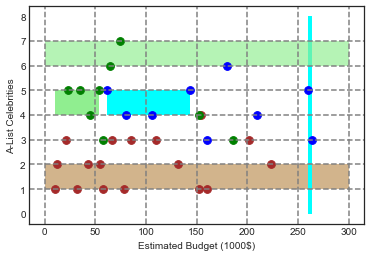

In [27]:
plotils.plot_quant_rules(transformed_rules)

# Step by step transformation

## Refitting

In [30]:
refitted_rules = qcba_transformation.refitter.transform(quant_rules)

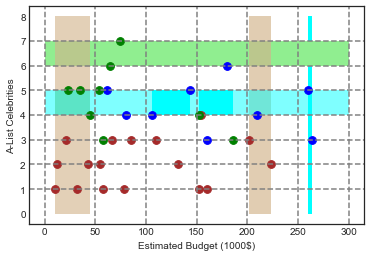

In [32]:
plotils.plot_quant_rules(refitted_rules)

## Literal pruning

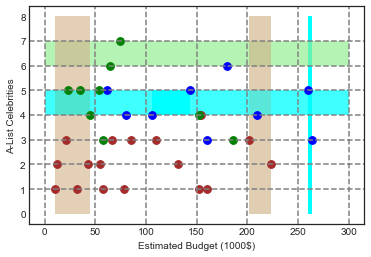

In [36]:
literal_pruned_rules = qcba_transformation.literal_pruner.transform(refitted_rules)

plotils.plot_quant_rules(literal_pruned_rules)

## Trimming

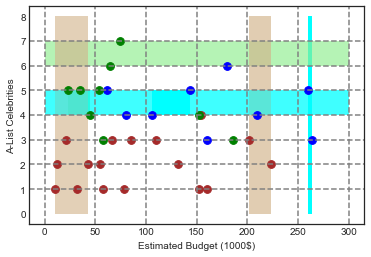

In [38]:
trimmed_rules = qcba_transformation.trimmer.transform(literal_pruned_rules)

plotils.plot_quant_rules(trimmed_rules)

## Extension

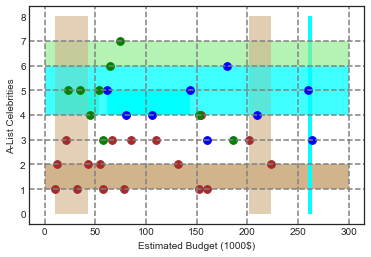

In [39]:
extended_rules = qcba_transformation.extender.transform(trimmed_rules)

plotils.plot_quant_rules(extended_rules)

## Postpruning

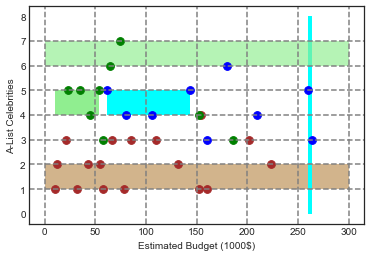

In [41]:
pruned_rules, default_class = qcba_transformation.post_pruner.transform(extended_rules)

plotils.plot_quant_rules(pruned_rules)

## Overlap pruning

In [42]:
qcba_transformation.overlap_pruner.transform(pruned_rules, default_class)

[]

# Single rules demonstration

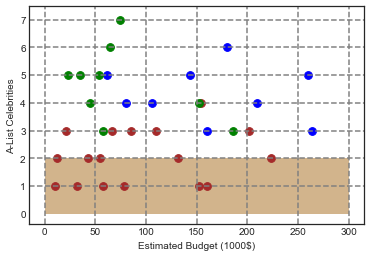

In [45]:
quant_rule1 = quant_rules[0]

plotils.plot_quant_rules([quant_rule1])

## Refitting

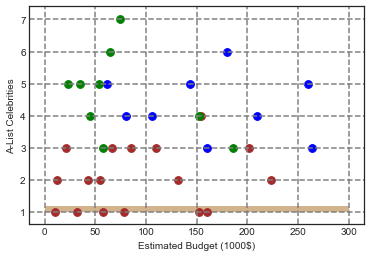

In [67]:
refitted_qrule1 = qcba_transformation.refitter.transform([quant_rule1])

# edit the maxval so that we can see the rule
refitted_qrule1[0].antecedent[0][1].maxval=1.2

plotils.plot_quant_rules(refitted_qrule1)

## Literal pruning

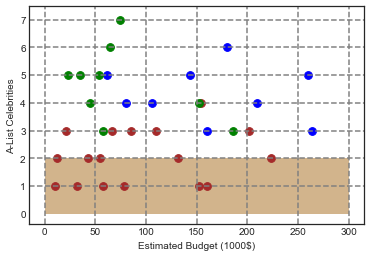

In [68]:
quant_rule1 = quant_rules[0]

plotils.plot_quant_rules([quant_rule1])

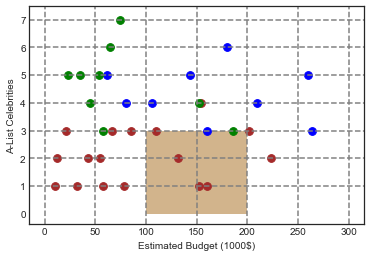

In [79]:
qrule_to_prune = quant_rule1.copy() 

# edit an item in antecedent to decrease confidence
# and see if the item gets pruned during literal pruning
# procedure
qrule_to_prune.antecedent[0] = "a-list-celebrities", Interval(0, 3, True, True)
qrule_to_prune.antecedent.append(("estimated-budget", Interval(100, 200, True, True)))

plotils.plot_quant_rules([qrule_to_prune])

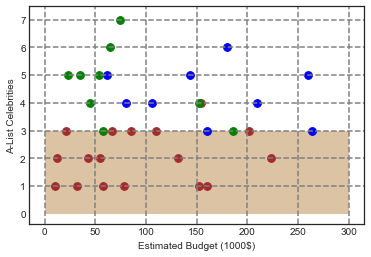

In [82]:
qrule1_literal_pruned = qcba_transformation.literal_pruner.transform([qrule_to_prune])


plotils.plot_quant_rules(qrule1_literal_pruned)

## Trimming

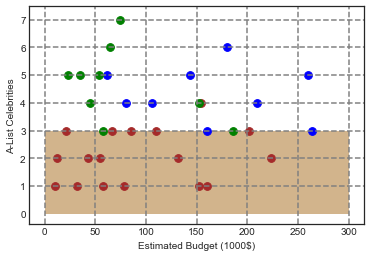

In [87]:
rule_to_trim = quant_rule1

rule_to_trim.antecedent[0] = "a-list-celebrities", Interval(0, 3, True, True)

plotils.plot_quant_rules([rule_to_trim])

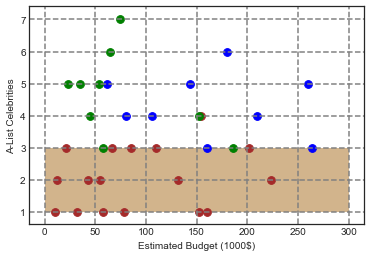

In [90]:
trimmed_rule = qcba_transformation.trimmer.transform([rule_to_trim])


plotils.plot_quant_rules(trimmed_rule)

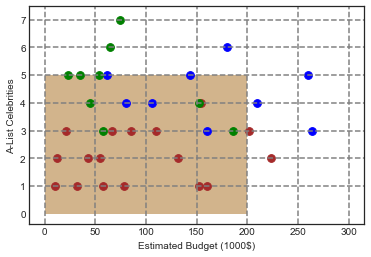

In [104]:
rule_to_extend = quant_rule1.copy()

rule_to_extend.antecedent = [
    ("a-list-celebrities", Interval(0, 5, True, True)),
    ("estimated-budget", Interval(0, 200, True, True))
]


plotils.plot_quant_rules([rule_to_extend])

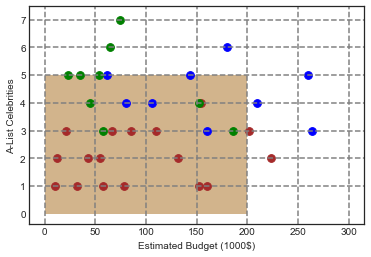

In [105]:
extended_rule = qcba_transformation.extender.transform([rule_to_extend])

plotils.plot_quant_rules(extended_rule)